In [85]:
import pandas as pd 

data = pd.read_csv('data.csv')

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data['malade'] = data['malade'].astype(int)
data['malade'] = data['malade'].astype(str)

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab


### Création d'un échantillon 

In [86]:
class_counts = data['nom_maladie'].value_counts()
species_counts = data['espece'].value_counts()
sick_counts = data['malade'].value_counts()

# Calcul du nombre d'images à prélever
num_images_per_class = round(1500 / len(class_counts))
num_images_per_species = round(1500 / len(species_counts))
num_images_sick = round(2000 / len(sick_counts))

# Création des échantillons équilibrés
sample = pd.DataFrame()
for class_name, count in class_counts.items():
    samples = data[data['nom_maladie'] == class_name].sample(min(count, num_images_per_class), random_state=42)
    sample = sample.append(samples)

for species_name, count in species_counts.items():
    samples = data[data['espece'] == species_name].sample(min(count, num_images_per_species), random_state=42)
    sample = sample.append(samples)

for sick_value, count in sick_counts.items():
    samples = data[data['malade'] == sick_value].sample(min(count, num_images_sick), random_state=42)
    sample = sample.append(samples)

# Mélange aléatoire
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\aissa\AppData\Local\Temp\ipykernel_54072\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_54072\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_54072\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_54072\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_54072\3821067970

C:\Users\aissa\AppData\Local\Temp\ipykernel_54072\3821067970.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)


In [87]:
sample

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Grape,1,Esca_(Black_Measles)
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Tomato,1,Early_blight
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Strawberry,1,Leaf_scorch
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Soybean,0,healthy
...,...,...,...,...
4984,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,0,healthy
4985,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
4986,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Potato,1,Late_blight
4987,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Tomato,1,Tomato_Yellow_Leaf_Curl_Virus


In [88]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [89]:
# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(sample.malade.unique())

num_classes

2

### Prétraitement des données

In [90]:
# Normalisation des pixels

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [91]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="malade",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='binary',
    subset='training'
)

Found 3992 validated image filenames belonging to 2 classes.


In [92]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="malade",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

Found 997 validated image filenames belonging to 2 classes.


### Modélisation sur l'échantillon

In [96]:
# CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [97]:
# Compilation du modèle

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
# Entraînement du modèle

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/8
62/62 [==============================] - 167s 3s/step - loss: 1.1092 - accuracy: 0.6963 - val_loss: 0.6748 - val_accuracy: 0.7896
Epoch 2/8
62/62 [==============================] - 169s 3s/step - loss: 0.5702 - accuracy: 0.8310 - val_loss: 0.5866 - val_accuracy: 0.7823
Epoch 3/8
62/62 [==============================] - 168s 3s/step - loss: 0.4934 - accuracy: 0.8396 - val_loss: 0.4475 - val_accuracy: 0.8521
Epoch 4/8
62/62 [==============================] - 168s 3s/step - loss: 0.4398 - accuracy: 0.8610 - val_loss: 0.4390 - val_accuracy: 0.8573
Epoch 5/8
62/62 [==============================] - 168s 3s/step - loss: 0.3877 - accuracy: 0.8707 - val_loss: 0.4058 - val_accuracy: 0.8646
Epoch 6/8
62/62 [==============================] - 167s 3s/step - loss: 0.4721 - accuracy: 0.8261 - val_loss: 0.4441 - val_accuracy: 0.8458
Epoch 7/8
62/62 [==============================] - 167s 3s/step - loss: 0.3710 - accuracy: 0.8887 - val_loss: 0.4014 - val_accuracy: 0.8594
Epoch 8/8
62/62 [===

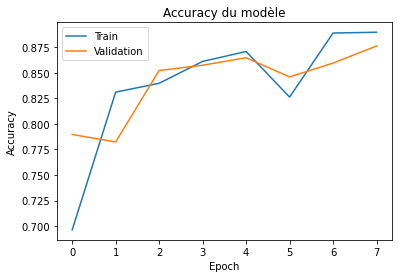

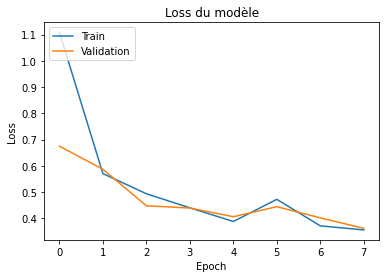

In [99]:
import matplotlib.pyplot as plt

# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Généralisation à l'ensemble du dataset

In [100]:
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Division du jeu de données en 10 dataframes équilibrés

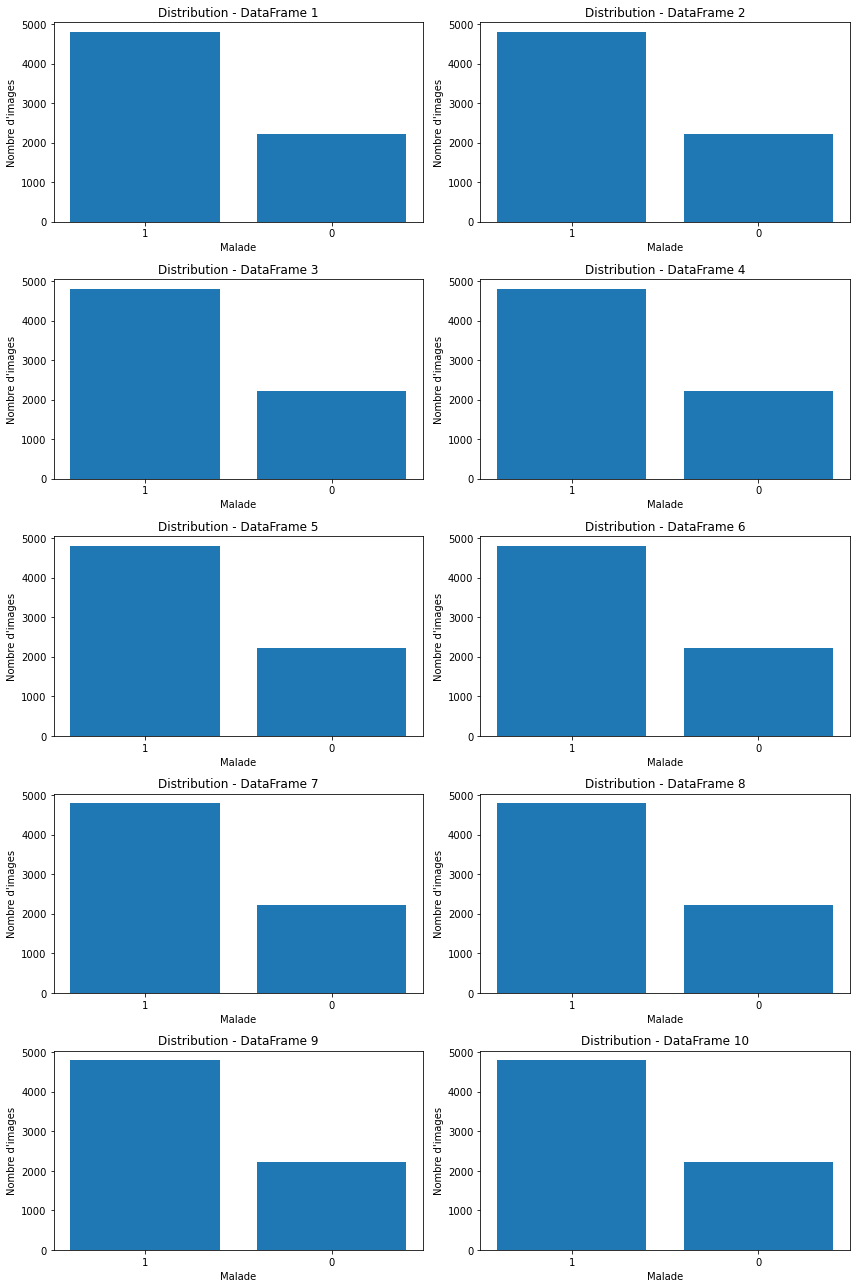

In [101]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['malade']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['malade'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Malade")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [105]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="malade",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='binary',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="malade",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='binary',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated ima

### Modélisation 

In [106]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    'cnn_id_malade.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(10):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 1.1461 - accuracy: 0.7176
Epoch 1: val_loss improved from inf to 0.70604, saving model to cnn_id_malade.h5
87/87 [==============================] - 241s 3s/step - loss: 1.1461 - accuracy: 0.7176 - val_loss: 0.7060 - val_accuracy: 0.7805
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.8151
Epoch 2: val_loss improved from 0.70604 to 0.54288, saving model to cnn_id_malade.h5
87/87 [==============================] - 240s 3s/step - loss: 0.5967 - accuracy: 0.8151 - val_loss: 0.5429 - val_accuracy: 0.8021
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.8232
Epoch 3: val_loss improved from 0.54288 to 0.44743, saving model to cnn_id_malade.h5
87/87 [==============================] - 237s 3s/step - loss: 0.5321 - accuracy: 0.8232 - val_loss: 0.4474 - val_accuracy: 0.8534
Epoch 4/8
87/87 [==========================

87/87 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9590
Epoch 4: val_loss did not improve from 0.21550
87/87 [==============================] - 239s 3s/step - loss: 0.1891 - accuracy: 0.9590 - val_loss: 0.2625 - val_accuracy: 0.9278
Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9613
Epoch 5: val_loss did not improve from 0.21550
87/87 [==============================] - 239s 3s/step - loss: 0.1876 - accuracy: 0.9613 - val_loss: 0.2258 - val_accuracy: 0.9487
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9761
Epoch 6: val_loss improved from 0.21550 to 0.21236, saving model to cnn_id_malade.h5
87/87 [==============================] - 240s 3s/step - loss: 0.1555 - accuracy: 0.9761 - val_loss: 0.2124 - val_accuracy: 0.9554
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9716
Epoch 7: val_loss did not improve from 0.21236
87/87 [===============

87/87 [==============================] - 246s 3s/step - loss: 0.0922 - accuracy: 0.9926 - val_loss: 0.2196 - val_accuracy: 0.9420
Fin de l'entraînement du modèle pour data_7.

Entraînement du modèle pour data_8 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9540
Epoch 1: val_loss did not improve from 0.16115
87/87 [==============================] - 245s 3s/step - loss: 0.1888 - accuracy: 0.9540 - val_loss: 0.2042 - val_accuracy: 0.9449
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9791
Epoch 2: val_loss did not improve from 0.16115
87/87 [==============================] - 239s 3s/step - loss: 0.1357 - accuracy: 0.9791 - val_loss: 0.2153 - val_accuracy: 0.9457
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9808
Epoch 3: val_loss improved from 0.16115 to 0.15866, saving model to cnn_id_malade.h5
87/87 [==============================] - 237s 3s/step - loss: 0.1254 

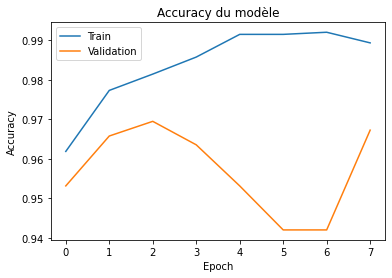

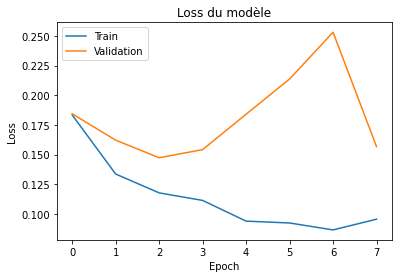

In [107]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test du modèle sur les données de validation

In [108]:
data_test = pd.read_csv('data_test.csv')

data_test['malade'] = data_test['malade'].astype(int)
data_test['malade'] = data_test['malade'].astype(str)

data_test.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab


In [109]:
# Prétraitement des images

image_size = (256, 256)
batch_size = 64

datagen = ImageDataGenerator(rescale=1.0/255.0)

data_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='img_path',
    y_col='malade',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=False  
)


Found 17572 validated image filenames belonging to 2 classes.


In [110]:
# Chargement du modèle 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.load_weights('cnn_id_malade.h5')

# Compilation 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_cnn_id_malade.h5')

In [115]:
import numpy as np

# Seuil pour déterminer la classe prédite
threshold = 0.5

# Prédiction des probabilités
predictions = model.predict(data_generator)

# Conversion des probabilités en classes prédites (0 ou 1)
predicted_labels = (predictions > threshold).astype(int)

275/275 [==============================] - 127s 461ms/step


In [116]:
true_labels = data_generator.classes
class_labels = data_generator.class_indices

Accuracy : 96.86%


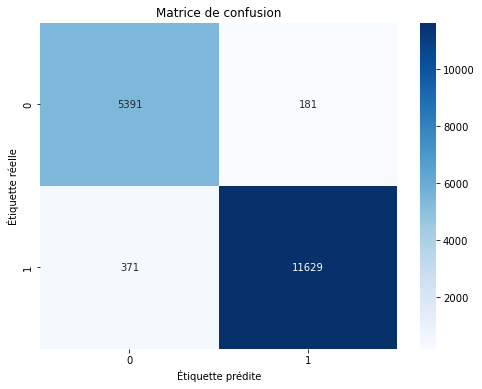

In [117]:
# Évaluation

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy : {:.2f}%".format(accuracy * 100))

import seaborn as sns

confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = np.unique(true_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()